# Fine-tuning for Video Classification with 🤗 Transformers



Before we start, let's install the `pytorchvideo`, `transformers`, and `evaluate` libraries.

In [ ]:
#!pip install pytorchvideo transformers evaluate -q
# choose this way of installing pythorchvideo to avoid import errors
!pip install pytorch-lightning
!pip install transformers evaluate -q
!git clone https://github.com/facebookresearch/pytorchvideo.git
%cd pytorchvideo
!pip install -e .
%cd ..
# needed to add this
!pip install accelerate -U
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install wandb
os.environ["WANDB_DISABLED"] = "true"
%env PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 54.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-man

In [ ]:
exit()

In [ ]:
!pip show pytorchvideo

Name: pytorchvideo
Version: 0.1.5
Summary: A video understanding deep learning library.
Home-page: https://github.com/facebookresearch/pytorchvideo
Author: Facebook AI
Author-email: 
License: Apache 2.0
Location: /content/pytorchvideo
Editable project location: /content/pytorchvideo
Requires: av, fvcore, iopath, networkx, parameterized
Required-by: 


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Then you need to install Git-LFS to upload your model checkpoints:

In [ ]:
!git config --global credential.helper store

Next mount google drive as videos are saved there locally

In [ ]:
from google.colab import drive
import sys
import os


drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/ucph')

root_path = '/content/drive/MyDrive/ucph/CCS2/data/'

os.chdir('/content/drive/MyDrive/ucph/CCS2/data/test')
test_filenames = os.listdir()
print(f" There are {len(test_filenames)} test files")

os.chdir('/content/drive/MyDrive/ucph/CCS2/data/train')
train_filenames = os.listdir()
print(f" There are {len(train_filenames)} train files")

os.chdir('/content/drive/MyDrive/ucph/CCS2/data')

Mounted at /content/drive
 There are 118 test files
 There are 541 train files


### Loading the dataset

Let's get the complete paths for each file.

In [ ]:
import pathlib

test_file_paths = [os.path.join(root_path, 'test', path) for path in test_filenames]
train_file_paths = [os.path.join(root_path, 'train', path) for path in train_filenames]

print(len(test_file_paths))
print(len(train_file_paths))

118
541


Next up, we derive the set of labels we have in the dataset. Let's also create two dictionaries that'll be helpful when initializing the model:

* `label2id`: maps the class names to integers.
* `id2label`: maps the integers to class names.

In [ ]:
class_labels = sorted({str(path).split("_")[0] for path in train_filenames})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

Unique classes: ['clear', 'slice', 'smash'].


We've got 3 unique classes.

In [ ]:
import pandas as pd

def create_df(file_pathsf):
  labels = []
  for file_path in file_pathsf:
    file_name = str(file_path).split("/")[-1]
    label = file_name.split("_")[0]
    labels.append(label)
  df = pd.DataFrame({'PATH': file_path, 'LABEL': labels})
  return df

train_df = create_df(train_file_paths)
test_df = create_df(test_file_paths)

# train_df = train_df.sample(frac=1, random_state=42)
# test_df = test_df.sample(frac=1, random_state=42)

print(len(train_df), train_df.sample(5))
print(len(test_df), test_df.sample(5))

541                                                   PATH  LABEL
229  /content/drive/MyDrive/ucph/CCS2/data/train/sm...  clear
73   /content/drive/MyDrive/ucph/CCS2/data/train/sm...  smash
352  /content/drive/MyDrive/ucph/CCS2/data/train/sm...  slice
86   /content/drive/MyDrive/ucph/CCS2/data/train/sm...  slice
470  /content/drive/MyDrive/ucph/CCS2/data/train/sm...  clear
118                                                   PATH  LABEL
79   /content/drive/MyDrive/ucph/CCS2/data/test/sma...  smash
103  /content/drive/MyDrive/ucph/CCS2/data/test/sma...  slice
62   /content/drive/MyDrive/ucph/CCS2/data/test/sma...  slice
94   /content/drive/MyDrive/ucph/CCS2/data/test/sma...  smash
107  /content/drive/MyDrive/ucph/CCS2/data/test/sma...  clear


### Loading the model

In the next cell, we initialize a video classification model where the encoder is initialized with the pre-trained parameters and the classification head is randomly initialized. We also initialize the feature extractor associated to the model. This will come in handy during writing the preprocessing pipeline for our dataset.

In [ ]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification

# model_ckpt = "sayakpaul/videomae-base-finetuned-kinetics-finetuned-ucf101-subset"
model_ckpt = "MCG-NJU/videomae-base" # pre-trained model from which to fine-tune
batch_size = 2 # batch size for training and evaluation


The warning is telling us we are throwing away some weights (e.g. the weights and bias of the `classifier` layer) and randomly initializing some other (the weights and bias of a new `classifier` layer). This is expected in this case, because we are adding a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

### Constructing the datasets for training

For preprocessing the videos, we'll leverage the [PyTorch Video library](https://pytorchvideo.org/). We start by importing the dependencies we need.

In [ ]:
import pytorchvideo.data
import pytorch_lightning
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

For the training dataset transformations, we use a combination of uniform temporal subsampling, pixel normalization, random cropping, and random horizontal flipping. For the validation and evaluation dataset transformations, we keep the transformation chain the same except for random cropping and horizontal flipping. To learn more about the details of these transformations check out the [official documentation of PyTorch Video](https://pytorchvideo.org).  

We'll use the `image_processor` associated with the pre-trained model to obtain the following information:

* Image mean and standard deviation with which the video frame pixels will be normalized.
* Spatial resolution to which the video frames will be resized.

As Im not working with the UCF-101 Dataset and my data has not a similar structure I need to create my own DatasetLoader


[Source](https://github.com/enrico310786/video_classification/blob/master/data.py)




In [ ]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification

image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
    )


Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

# https://pytorch.org/hub/facebookresearch_pytorchvideo_resnet/
import torch
import os
from pytorchvideo.data.encoded_video import EncodedVideo
from torchvision.transforms import Compose, Lambda, Resize
from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo,
)
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample
)
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader

mean = image_processor.image_mean
std = image_processor.image_std
side_size = 224
crop_size = 224
num_frames = 16

class ClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, df_dataset) -> None:
        super().__init__()

        self.df_dataset = df_dataset
        do_crop_video = True

        if do_crop_video:
            print("do_crop_video TRUE")
            self.transform = ApplyTransformToKey(
                key="video",
                transform=Compose(
                    [
                        UniformTemporalSubsample(num_frames),
                        Lambda(lambda x: x/255.0),
                        NormalizeVideo(mean, std),
                        ShortSideScale(size=side_size),
                        CenterCropVideo(crop_size=(crop_size, crop_size))
                    ]
                ),
            )
        else:
            print("do_crop_video FALSE")
            self.transform = ApplyTransformToKey(
                key="video",
                transform=Compose(
                    [
                        UniformTemporalSubsample(num_frames),
                        Lambda(lambda x: x/255.0),
                        NormalizeVideo(mean, std),
                        #Resize((crop_size, crop_size))
                        #ShortSideScale(size=side_size)
                    ]
                ),
            )

    def __len__(self):
        return len(self.df_dataset)

    def __getitem__(self, idx):
        video_path = self.df_dataset.iloc[idx]["PATH"]
        label = self.df_dataset.iloc[idx]["LABEL"]
        index = self.df_dataset.iloc[idx].name

        if not os.path.exists(video_path):
            print("The video '{}' does not exist ".format(video_path))

        video = EncodedVideo.from_path(video_path)
        start_time = 0.7 # why exactly this?
        end_sec = int(video.duration)
        video_data = video.get_clip(start_sec=start_time, end_sec=end_sec)
        video_data = self.transform(video_data)
        tensor = video_data["video"]

        """
        {
          'video': <video_tensor>,
          'label': <index_label>,
          'video_label': <index_label>
          'video_index': <video_index>,
          'clip_index': <clip_index>,
          'aug_index': <aug_index>,
        }
        """

        return {"video": tensor, "video_label": label, "label": label2id[label], "video_index": index, "clip_index": 0, "aug_index": 0}

def create_loaders(df):

    batch_size = 1

    # 1 - I instatiate the dataset class of train, val and test sets
    dataset = ClassificationDataset(df_dataset=df)



    # 2 - I instatiate the dataloader
    dataloader = DataLoader(dataset=dataset,
                                                 batch_size=batch_size,
                                                 shuffle=True,
                                                 num_workers=0,
                                                 drop_last=False)

    return dataset, dataloader

train_dataset, train_dataloader = create_loaders(train_df)
test_dataset, test_dataloader = create_loaders(test_df)



do_crop_video TRUE
do_crop_video TRUE


In [ ]:
print(type(train_dataset))

<class '__main__.ClassificationDataset'>


Let's now take a preprocessed video from the dataset and investigate it.

In [ ]:
# attention i defined the batch size = 2 therefore i get two samples!
sample = next(iter(train_dataloader))
label = sample['label']
#tensor = sample[0].squeeze(0)
tensor = sample['video'].squeeze(0)
sample = train_df.iloc[0]
print(sample.name)
sample_video = next(iter(train_dataset))
sample_video.keys()

0


dict_keys(['video', 'video_label', 'label', 'video_index', 'clip_index', 'aug_index'])

In [ ]:
def investigate_video(sample_video):
    """Utility to investigate the keys present in a single video sample."""
    for k in sample_video:
        if k == "video":
            print(k, sample_video["video"].shape)
        else:
            print(k, sample_video[k])

    print(f"Video label: {id2label[sample_video[k]]}")


investigate_video(sample_video)

video torch.Size([3, 16, 224, 224])
video_label slice
label 1
video_index 0
clip_index 0
aug_index 0
Video label: clear


We can also visualize the preprocessed videos for easier debugging.

In [ ]:
import imageio
import numpy as np
from IPython.display import Image


def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)


def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.

    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename


def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

torch.Size([3, 16, 224, 224])


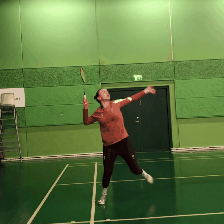

In [ ]:
print(tensor.shape)
display_gif(tensor, gif_name="sample-train.gif")

### Training the model

We'll leverage [`Trainer`](https://huggingface.co/docs/transformers/main_classes/trainer) from  🤗 Transformers for training the model. To instantiate a `Trainer`, we will need to define the training configuration and an evaluation metric. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to configure the training. It requires an output folder name, which will be used to save the checkpoints of the model. It also helps sync all the information in the model repository on 🤗 Hub.

Most of the training arguments are pretty self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('video' in particular) in order to create `pixel_values` (which is a mandatory key our model expects in its inputs).

There's no need to define `max_steps` when instantiating `TrainingArguments`. Since the dataset returned by `pytorchvideo.data.Ucf101()` doesn't implement the `__len__()` method we had to specify `max_steps`.  

Next, we need to define a function for how to compute the metrics from the predictions, which will just use the `metric` we'll load now. The only preprocessing we have to do is to take the argmax of our predicted logits:

In [ ]:
import evaluate

metric = evaluate.load("accuracy")

In [ ]:
# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions."""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

**A note on evaluation**:

In the [VideoMAE paper](https://arxiv.org/abs/2203.12602), the authors use the following evaluation strategy. They evaluate the model on several clips from test videos and apply different crops to those clips and report the aggregate score. However, in the interest of simplicity and brevity, we don't consider that in this tutorial.

We also define a `collate_fn`, which will be used to batch examples together.
Each batch consists of 2 keys, namely `pixel_values` and `labels`.

In [ ]:
import torch


def collate_fn(examples):
    """The collation function to be used by `Trainer` to prepare data batches."""
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [ ]:
from sklearn.model_selection import KFold
from transformers import TrainingArguments, Trainer

# wandb.init(project='video_classification_test', entity='rstern')
"""
kf = KFold(n_splits = 10, shuffle = True, random_state = 0)
for (train_index, val_index), fold in zip(kf.split(train_df), range(10)):
    train_dataset = train_df.iloc[train_index]
    val_dataset = train_df.iloc[val_index]

    break
"""
print(len(train_dataset), len(test_dataset))


model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-badminton-{fold}"

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    # push_to_hub=True,
    # max_steps=100,
)

trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

train_results = trainer.train()

# wandb.finish()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


541 118


Epoch,Training Loss,Validation Loss,Accuracy
1,1.078000,1.141845,0.330508
2,1.078900,1.112263,0.330508


You might wonder why we pass along the `image_processor` as a tokenizer when we already preprocessed our data. This is only to make sure the feature extractor configuration file (stored as JSON) will also be uploaded to the repo on the hub.

Now we can finetune our model by calling the `train` method:

We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one):

In [ ]:
trainer.evaluate(test_dataset)

{'eval_loss': 1.2670117616653442,
 'eval_accuracy': 0.3728813559322034,
 'eval_runtime': 167.8503,
 'eval_samples_per_second': 0.703,
 'eval_steps_per_second': 0.352,
 'epoch': 0.03690036900369004}

In [ ]:
trainer.save_model()
test_results = trainer.evaluate(test_dataset)
trainer.log_metrics("test", test_results)
trainer.save_metrics("test", test_results)
trainer.save_state()

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

events.out.tfevents.1713339269.8125ea423e91.6322.1:   0%|          | 0.00/24.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/345M [00:00<?, ?B/s]

events.out.tfevents.1713341739.8125ea423e91.6322.2:   0%|          | 0.00/411 [00:00<?, ?B/s]

***** test metrics *****
  epoch                   =       3.25
  eval_accuracy           =     0.8323
  eval_loss               =     0.4875
  eval_runtime            = 0:01:07.35
  eval_samples_per_second =      2.301
  eval_steps_per_second   =      1.158


You can now upload the result of the training to the Hub, just execute this instruction (note that the Trainer will automatically create a model card as well as Tensorboard logs - see the "Training metrics" tab - amazing isn't it?):

In [ ]:
trainer.push_to_hub()

Now that our model is trained, let's use it to run inference on a video from `test_dataset`.

## Inference

Let's load the trained model checkpoint and fetch a video from `test_dataset`.

In [ ]:
trained_model = VideoMAEForVideoClassification.from_pretrained(new_model_name)

In [ ]:
sample_test_video = next(iter(test_dataset))
investigate_video(sample_test_video)

video torch.Size([3, 16, 224, 224])
video_name v_BasketballDunk_g12_c05.avi
video_index 62
clip_index 0
aug_index 0
label 8
Video label: BasketballDunk


We then prepare the video as a `torch.Tensor` and run inference.

In [ ]:
def run_inference(model, video):
    """Utility to run inference given a model and test video.

    The video is assumed to be preprocessed already.
    """
    # (num_frames, num_channels, height, width)
    perumuted_sample_test_video = video.permute(1, 0, 2, 3)

    inputs = {
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),
        "labels": torch.tensor(
            [sample_test_video["label"]]
        ),  # this can be skipped if you don't have labels available.
    }
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    return logits

In [ ]:
logits = run_inference(trained_model, sample_test_video["video"])

We can now check if the model got the prediction right.

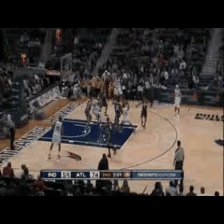

In [ ]:
display_gif(sample_test_video["video"])

In [ ]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: BasketballDunk


And it looks like it got it right!

You can also use this model to bring in your own videos. Check out [this Space](https://huggingface.co/spaces/sayakpaul/video-classification-ucf101-subset) to know more. The Space will also show you how to run inference for a single video file.

<br><div align=center>
    <img src="https://i.ibb.co/7nW4Rkn/sample-results.gif" width=700/>
</div>

## Next steps

Now that you've learned to train a well-performing video classification model on a custom dataset here is some homework for you:

* Increase the dataset size: include more classes and more samples per class.
* Try out different hyperparameters to study how the model converges.
* Analyze the classes for which the model fails to perform well.
* Try out a different video encoder.

Don't forget to share your models with the community =)